1. General intro to synphys / MP
2. Intro to dataset and sqlalchemy
 - database structure
 - project names
 - querying cell pairs
3. Connectivity
 - proportions / binomial CI
 - lateral distance profiles, fitting
 - cell_class_nonsynaptic
 - experimental bias corrections
4. Synapse features
 - Strength
 - Kinetics
 - STP
5. Stochastic release model
 - Getting max likelihood model parameters
 - Full parameter space results

Run this cell to show the TOC at left:

In [1]:
%%javascript
$('<div id="toc"><b>Contents</b><br><ol><li><a href="#introduction">Introduction</a></div>').css({position: 'fixed', top: '120px', left: 0, border: '1px solid #000', padding: '5px'}).appendTo(document.body);

<IPython.core.display.Javascript object>

Tutorial: Synaptic connectivity and dynamics in mouse and human cortex
============================================================

This tutorial will show you how to access the [Synaptic Physiology Dataset](https://portal.brain-map.org/explore/connectivity/synaptic-physiology) from the Allen Institute for Brain Science. This dataset describes properties of synapses that were recorded using patch-clamp electrophysiology in mouse and human neocortical tissue. The main purpose is to understand the relationship between _cell types_ and _synapse properties_ in local microcircuits:

- What is the probability of finding a synaptic connection between two cells, and how is that affected by cell type? 
- How is connectivity affected by the distance between two cells, or by other experimental parameters?
- How is cell type related to other synapse properties such as strength, latency, kinetics (PSP shape), and dynamics (stochasticity and short-term plasticity)?
- How can we best model synaptic connectivity and dynamics, and what can these models tell us about the function of the microcircuit?

Multi-patch electrophysiology
------------------------------------------

The experiments in the Synaptic Physiology Dataset are performed using patch clamp electrophysiology in brain slices with up to 8 electrodes simultaneously. The resulting data are complex; understanding the limitations of the experimental methods is necessary in order to avoid analysis mistakes. For complete details on our methods, see our  [website](https://portal.brain-map.org/explore/connectivity/synaptic-physiology) and recent [bioRxiv publication (currently in review)](https://www.biorxiv.org/content/10.1101/2021.03.31.437553v2). When in doubt, you can ask questions on our [forum](https://community.brain-map.org/) with the tag `synaptic-physiology`.

In patch-clamp electrophysiology, we use glass electrodes to gain direct electrical access to the _interior_ of a neuron. This allows us to precisely control the spiking of individual cells and to record synaptic currents that are too small to be observed by any other method (for now). 

![multipatch](source/images/multipatch.svg)

In a single experiment, we patch up to 8 neurons simultaneously. Each neuron is stimulated to fire patterns of action potentials while we record the membrane potential of the other neurons. If two neurons are connected by a synapse, we should be able to see synaptic currents within a few ms of each presynaptic spike (although many synapses require averaging to reduce noise before the response is visible).

<a name="introduction"></a>

Indroduction to dataset and database
---------------------------------------

The Synaptic Physiology Dataset contains the results of thousands of multipatch experiments. For each experiment, we store three major types of information:

- **Experiment metadata:** species, brain region, and experimental conditions
- **Cell properties:** location (including cortical layer), morphology, transgenic reporters, and intrinsic electrophysiological features
- **Synapse properties:** strength, latency, kinetics (PSP shape), and dynamics (variance and short-term plasticity)

These data are stored in a relational database (an sqlite file) and spread out over many tables. It is possible to access these tables using SQL or sqlalchemy; however, for this tutorial we will use helper methods that handle most of the queries for us.

As a simple starting point, let's get a dataframe that describes the properties of all human synapses in the dataset:

In [44]:
from aisynphys.database import default_db as db

query = db.pair_query(
    experiment_type='standard_multipatch',
    species='human',
    synapse=True,          
    preload=['synapse'],
)
synapses = query.dataframe()

synapses.head()

,pair.id,pair.experiment_id,pair.pre_cell_id,pair.post_cell_id,pair.has_synapse,pair.has_polysynapse,pair.has_electrical,pair.crosstalk_artifact,pair.n_ex_test_spikes,pair.n_in_test_spikes,...,synapse_model.ml_variability_stp_induced_state_50hz,synapse_model.ml_variability_change_initial_50hz,synapse_model.ml_variability_change_induction_50hz,synapse_model.ml_paired_event_correlation_1_2_r,synapse_model.ml_paired_event_correlation_1_2_p,synapse_model.ml_paired_event_correlation_2_4_r,synapse_model.ml_paired_event_correlation_2_4_p,synapse_model.ml_paired_event_correlation_4_8_r,synapse_model.ml_paired_event_correlation_4_8_p,synapse_model.meta
0,10845,226,1630,1629,True,False,False,NaN,179,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None
1,10923,229,1644,1659,True,False,False,NaN,740,0,...,-0.372603,-0.151901,0.086990,-0.102920,0.021351,-0.133563,0.002767,-0.259929,3.649414e-09,{'pair_ext_id': '1488403059.445 2 8'}
2,11166,229,1659,1644,True,False,False,NaN,745,2,...,0.800434,0.563251,1.560376,-0.016723,0.709134,0.056313,0.208735,0.059376,1.849966e-01,{'pair_ext_id': '1488403059.445 8 2'}
3,20594,448,3160,3168,True,False,False,NaN,610,120,...,1.640283,-1.611586,-0.428663,-0.014364,0.748663,-0.006153,0.890836,0.044243,3.234863e-01,{'pair_ext_id': '1522188414.230 1 6'}
4,20630,448,3168,3166,True,False,False,NaN,597,120,...,-0.083542,0.554579,0.314799,0.033411,0.456005,0.001192,0.978789,0.017851,6.904899e-01,{'pair_ext_id': '1522188414.230 6 5'}


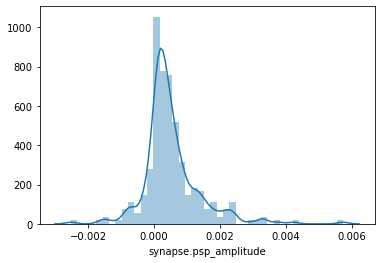

In [48]:
import seaborn

seaborn.distplot(synapses['synapse.psp_amplitude'])

<a name="connectivity"></a>

Measuring connectivity
---------------------------------



In [ ]:
# Download and cache the sqlite file for the requested database
#   (for available versions, see SynphysDatabase.list_versions)
#db = SynphysDatabase.load_version('synphys_r2.0-pre1_small.sqlite')
from aisynphys.database import default_db as db

# Load all cell pairs associated with mouse multipatch projects
mouse_pairs = db.pair_query(experiment_type='standard multipatch', species='mouse', preload=['cell']).all()

print("loaded %d cell pairs" % len(mouse_pairs))

In [43]:
db.query(db.Experiment).count()

4687

A single cell `pair` represents a _possible_ connection from one cell to another:

In [ ]:
# print some information about the last cell pair returned
pair = mouse_pairs[-1]
print("Cell pair:", pair)
print("  presynaptic subclass:", pair.pre_cell.cre_type)
print("  postsynaptic subclass:", pair.post_cell.cre_type)
print("  synaptic connection:", "yes" if pair.has_synapse else "no")

### 2. Define cell _classes_

We want to group together all cell pairs based on their pre- and postsynaptic cell classes. However, there are many different ways to classify cells so we must first define the criteria for all cell classes that we want to compare:

In [ ]:
cell_class_criteria = {
    'l23pyr': {'dendrite_type': 'spiny',       'cortical_layer': '2/3'},
    'l23pv':  {'cre_type': 'pvalb',            'cortical_layer': '2/3'},
    'l23sst': {'cre_type': 'sst',              'cortical_layer': '2/3'},
    'l23vip': {'cre_type': 'vip',              'cortical_layer': '2/3'},
    'l4pyr':  {'cre_type': ('nr5a1', 'rorb'),  'cortical_layer': '4'},
    'l4pv':   {'cre_type': 'pvalb',            'cortical_layer': '4'},
    'l4sst':  {'cre_type': 'sst',              'cortical_layer': '4'},
    'l4vip':  {'cre_type': 'vip',              'cortical_layer': '4'},
    'l5et':   {'cre_type': ('sim1', 'fam84b'), 'cortical_layer': '5'},
    'l5it':   {'cre_type': 'tlx3',             'cortical_layer': '5'}, 
    'l5pv':   {'cre_type': 'pvalb',            'cortical_layer': '5'},
    'l5sst':  {'cre_type': 'sst',              'cortical_layer': '5'},
    'l5vip':  {'cre_type': 'vip',              'cortical_layer': '5'},
    'l6pyr':  {'cre_type': 'ntsr1',            'cortical_layer': ('6a','6b')},
    'l6pv':   {'cre_type': 'pvalb',            'cortical_layer': ('6a','6b')},
    'l6sst':  {'cre_type': 'sst',              'cortical_layer': ('6a','6b')},
    'l6vip':  {'cre_type': 'vip',              'cortical_layer': ('6a','6b')},
}

Create a `CellClass` object to represent each cell class described above:

In [ ]:
from aisynphys.cell_class import CellClass

cell_classes = {name:CellClass(name=name, **criteria) for name,criteria in cell_class_criteria.items()}

### 3. Measure connection probability between classes

In [ ]:
from aisynphys.cell_class import classify_cells, classify_pairs
from aisynphys.connectivity import measure_connectivity

# Group all cells by selected classes
cell_groups = classify_cells(cell_classes.values(), pairs=mouse_pairs)

# Group pairs into (pre_class, post_class) groups
pair_groups = classify_pairs(mouse_pairs, cell_groups)

# analyze matrix elements
results = measure_connectivity(pair_groups, sigma=150e-6)

At this point we have all data loaded and connection probabilities have been computed. For each combination of (presynaptic_class, postsynaptic_class), we have a result dictionary that includes the number of putative connections probed, the number of synapses found, and the connection probability with 95% confidence intervals.

**The results for a single connection type look like:**

In [ ]:
# pick two arbitrary cell classes to display results from
pre_class = cell_classes['l23sst']
post_class = cell_classes['l23vip']

print("Connectivity results for %s => %s" % (pre_class, post_class))
print("  %d synapses found out of %d probed" % (
    results[pre_class, post_class]['n_connected'],
    results[pre_class, post_class]['n_probed'],
))
print("  %0.2f%% connection probability" % (
    results[pre_class, post_class]['connection_probability'][0] * 100,
))
print("     95%% confidence interval: %0.2f%%-%0.2f%%" % (
    results[pre_class, post_class]['connection_probability'][1] * 100,
    results[pre_class, post_class]['connection_probability'][2] * 100,
))
print("  %0.2f%% distance-adjusted connection probability" % (
    results[pre_class, post_class]['adjusted_connectivity'][0] * 100,
))
print("     95%% confidence interval: %0.2f%%-%0.2f%%" % (
    results[pre_class, post_class]['adjusted_connectivity'][1] * 100,
    results[pre_class, post_class]['adjusted_connectivity'][2] * 100,
))
    

### 4. Display conectivity heat map

Now we want to take the entire set of results computed above (for all connection types) and display a heat map where the color represents the probability of connection. 

To do this, we must first transform the results into 2D arrays of colors and labels, and then construct the heat map with a few calls to matplotlib. The function defined below 

In [ ]:
import matplotlib.colors, matplotlib.cm
import matplotlib.pyplot as plt
from aisynphys.ui.notebook import show_connectivity_matrix
%matplotlib inline

# define a colormap and log normalization used to color the heatmap
norm = matplotlib.colors.LogNorm(vmin=0.01, vmax=1.0, clip=True)
cmap = matplotlib.cm.get_cmap('plasma')

# define the display labels to use for each cell subclass:
class_labels = {
    'l23pyr': 'L2/3 Pyr\nspiny',
    'l23pv':  'L2/3 Pv',
    'l23sst': 'L2/3 Sst',
    'l23vip': 'L2/3 Vip',
    'l4pyr':  'L4 Pyr\n nr5a1',
    'l4pv':   'L4 Pv',
    'l4sst':  'L4 Sst',
    'l4vip':  'L4 Vip',
    'l5et':   'L5 Pyr ET\nsim1, fam84b',
    'l5it':   'L5 Pyr IT\ntlx3',
    'l5pv':   'L5 Pv',
    'l5sst':  'L5 Sst',
    'l5vip':  'L5 Vip',
    'l6pyr':  'L6 Pyr\nntsr1',
    'l6pv':   'L6 Pv',
    'l6sst':  'L6 Sst',
    'l6vip':  'L6 Vip',
}

# create a figure/axes to draw on
fig, ax = plt.subplots(figsize=(15, 15))

# finally, draw the colormap using the provided function:
im, cbar, labels = show_connectivity_matrix(
    ax=ax, 
    results=results, 
    pre_cell_classes=cell_classes.values(), 
    post_cell_classes=cell_classes.values(), 
    class_labels=class_labels, 
    cmap=cmap, 
    norm=norm,
    distance_adjusted=True
)

<a name="features"></a>

Synapse features
-------------------------



<a name="model"></a>

Stochastic release model
---------------------------------------



Sandbox!

In [1]:
import pandas
pandas.set_option('display.max_columns', None)

In [1]:
from aisynphys.database import default_db as db


In [2]:
pairs = db.pair_query(experiment_type='standard multipatch').all()
from aisynphys.connectivity import pair_was_probed
probed = [pair_was_probed(pair, pair.pre_cell.cell_class) for pair in pairs]
print(len(pairs), sum(probed))

93132 26417


In [3]:
df = db.pair_query(experiment_type='standard multipatch', preload=['experiment', 'cell']).dataframe()
print(len(df))

93132


In [4]:
df = db.pair_query(experiment_type='standard multipatch', preload=['experiment', 'cell'], synapse_probed=True).dataframe()
print(len(df))

26417


In [4]:
df['pre_cell.cre_type'].unique()

array(['unknown', 'sst', 'vip', 'pvalb', 'sim1', 'ntsr1', 'rorb', 'nr5a1',
       'tlx3', 'cux2', 'fam84b', 'slc17a8', 'sst,pvalb', 'rbp4',
       'sim1,pvalb', 'vip,sim1', 'chat', 'vip,tlx3', 'sim1,vip',
       'nr5a1,pvalb', 'vip,pvalb', 'pvalb,sst'], dtype=object)

In [9]:
from aisynphys.cell_class import CellClass, classify_pair_dataframe

In [10]:
cell_class_criteria = {
    'l23pyr': {'dendrite_type': 'spiny',       'cortical_layer': '2/3'},
    'l23pv':  {'cre_type': 'pvalb',            'cortical_layer': '2/3'},
    'l23sst': {'cre_type': 'sst',              'cortical_layer': '2/3'},
    'l23vip': {'cre_type': 'vip',              'cortical_layer': '2/3'},
    'l4pyr':  {'cre_type': ('nr5a1', 'rorb'),  'cortical_layer': '4'},
    'l4pv':   {'cre_type': 'pvalb',            'cortical_layer': '4'},
    'l4sst':  {'cre_type': 'sst',              'cortical_layer': '4'},
    'l4vip':  {'cre_type': 'vip',              'cortical_layer': '4'},
    'l5et':   {'cre_type': ('sim1', 'fam84b'), 'cortical_layer': '5'},
    'l5it':   {'cre_type': 'tlx3',             'cortical_layer': '5'}, 
    'l5pv':   {'cre_type': 'pvalb',            'cortical_layer': '5'},
    'l5sst':  {'cre_type': 'sst',              'cortical_layer': '5'},
    'l5vip':  {'cre_type': 'vip',              'cortical_layer': '5'},
    'l6pyr':  {'cre_type': 'ntsr1',            'cortical_layer': ('6a','6b')},
    'l6pv':   {'cre_type': 'pvalb',            'cortical_layer': ('6a','6b')},
    'l6sst':  {'cre_type': 'sst',              'cortical_layer': ('6a','6b')},
    'l6vip':  {'cre_type': 'vip',              'cortical_layer': ('6a','6b')},
}
cell_classes = {k:CellClass(**v) for k,v in cell_class_criteria.items()}

In [11]:
classify_pair_dataframe(cell_classes, df)

In [28]:
probed = df.pivot_table(values='pair.id', index='pre_class', columns='post_class', aggfunc=len, fill_value=1)
connected = df.pivot_table(values='pair.has_synapse', index='pre_class', columns='post_class', aggfunc=sum, fill_value=0)

In [29]:
connected[connected==False] = 0

In [30]:
connected/probed

post_class,l23pv,l23pyr,l23sst,l23vip,l4pv,l4pyr,l4sst,l4vip,l5et,l5it,l5pv,l5sst,l5vip,l6pv,l6pyr,l6sst,l6vip
pre_class,,,,,,,,,,,,,,,,,
l23pv,0.380952,0.320755,0.073529,0.0,0.2,0.1875,0.0,0.0,0.090909,0.142857,0.190476,0.0,0.333333,0.0,0.0,0.0,0.0
l23pyr,0.396226,0.064039,0.3125,0.183333,0.259259,0.027027,0.214286,0.0,0.2,0.0,0.0,0.04,0.0,0.0,0.0,0.0,0.0
l23sst,0.15625,0.240741,0.032258,0.387097,0.277778,0.032258,0.0,0.25,0.0,0.0,0.111111,0.0,0.0,0.0,0.0,0.0,0.0
l23vip,0.017857,0.052632,0.151515,0.013072,0.0,0.0,0.133333,0.045455,0.0,0.0,0.0625,0.0,0.041667,0.0,0.0,0.0,0.0
l4pv,0.296296,0.333333,0.055556,0.052632,0.472222,0.2,0.0,0.088889,0.076923,0.16129,0.25,0.0,0.0,0.5,0.0,0.0,0.0
l4pyr,0.25,0.028571,0.032258,0.02381,0.113636,0.103376,0.035714,0.038462,0.0,0.0,0.352941,0.029412,0.105263,0.0,0.0,0.0,0.0
l4sst,0.0,0.285714,0.0,0.258065,0.0,0.222222,0.0,0.285714,0.0,0.166667,0.0,0.031746,0.071429,0.0,0.0,0.0,0.0
l4vip,0.0,0.0,0.25,0.0,0.022222,0.0,0.172414,0.022901,0.0,0.0,0.0625,0.111111,0.03125,0.0,0.0,0.0,0.0
l5et,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.076177,0.0,0.080645,0.082192,0.0,0.0,0.0,0.0,0.0


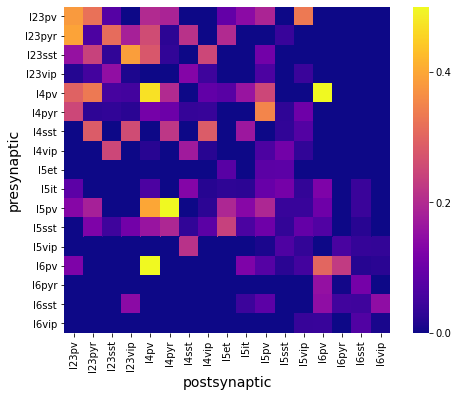

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns

fig,ax = plt.subplots(figsize=(8, 6))

hm = sns.heatmap(
    (connected/probed).astype(float), 
    cmap='plasma', vmin=0, vmax=0.5, square=True, ax=ax,
    cbar_kws={"ticks":[0, 0.2, 0.4, 0.6, 0.8, 1.0]}
)

hm.set_xlabel("postsynaptic", fontsize=14)
hm.set_ylabel("presynaptic", fontsize=14);

In [34]:
(connected/probed).astype(float)

post_class,l23pv,l23pyr,l23sst,l23vip,l4pv,l4pyr,l4sst,l4vip,l5et,l5it,l5pv,l5sst,l5vip,l6pv,l6pyr,l6sst,l6vip
pre_class,,,,,,,,,,,,,,,,,
l23pv,0.380952,0.320755,0.073529,0.000000,0.200000,0.187500,0.000000,0.000000,0.090909,0.142857,0.190476,0.000000,0.333333,0.000000,0.000000,0.000000,0.000000
l23pyr,0.396226,0.064039,0.312500,0.183333,0.259259,0.027027,0.214286,0.000000,0.200000,0.000000,0.000000,0.040000,0.000000,0.000000,0.000000,0.000000,0.000000
l23sst,0.156250,0.240741,0.032258,0.387097,0.277778,0.032258,0.000000,0.250000,0.000000,0.000000,0.111111,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
l23vip,0.017857,0.052632,0.151515,0.013072,0.000000,0.000000,0.133333,0.045455,0.000000,0.000000,0.062500,0.000000,0.041667,0.000000,0.000000,0.000000,0.000000
l4pv,0.296296,0.333333,0.055556,0.052632,0.472222,0.200000,0.000000,0.088889,0.076923,0.161290,0.250000,0.000000,0.000000,0.500000,0.000000,0.000000,0.000000
l4pyr,0.250000,0.028571,0.032258,0.023810,0.113636,0.103376,0.035714,0.038462,0.000000,0.000000,0.352941,0.029412,0.105263,0.000000,0.000000,0.000000,0.000000
l4sst,0.000000,0.285714,0.000000,0.258065,0.000000,0.222222,0.000000,0.285714,0.000000,0.166667,0.000000,0.031746,0.071429,0.000000,0.000000,0.000000,0.000000
l4vip,0.000000,0.000000,0.250000,0.000000,0.022222,0.000000,0.172414,0.022901,0.000000,0.000000,0.062500,0.111111,0.031250,0.000000,0.000000,0.000000,0.000000
l5et,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.076177,0.000000,0.080645,0.082192,0.000000,0.000000,0.000000,0.000000,0.000000
